# Labsheet 3: Line Sensors

In previous lab sessions, you have:
- Seen the standard Arduino sketch, which has the structure of setup() and loop() routines.
- Experimented with Arduino Example sketches
- Uploaded sketches to your robot.
- Experimented with Serial commands to view debug output from your code.
- Controlled the power of the two motors with analogWrite()
- Developed your own motor `class`, neatly encapsulating the code for the motors.

This labsheet will serve as a good model for how we might investigate a new sensor, develop code for the sensor, and then validate the operation.

In this labsheet we will learn to operate the sensors for line detection.  On the 3Pi+ there are 5 of sensors facing toward the ground surface. These are visible beneath the robot, as annotated in the following image:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_BottomAnnotated.png?raw=true">
<br>
</p>


For basic operation of following a line, the 3 central sensors are most useful.  On the robot and in the documentation, these are labelled `DN2`, `DN3` and `DN4`.  The exercises in this labsheet omit the left-most (`DN1`) and right-most (`DN5`) sensors to simplify the learning process and tuition. After this labsheet, you might want to adapt your code to include these two further sensors.







<hr><br><br><br><br>

# 3Pi+ Line Sensors, Theory of Operation



<p align="center">
<br>
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_DN_ReflectanceHalf.png?raw=true">
<br>
</p>

The line following sensors operate by transmitting a beam of infra-red light and sensing the intensity of the reflection.  On the 3PI+ circuit board you can see them labelled as `DN1`, `DN2`, `DN3`, `DN4`,  and `DN5`.  The **`transducer`** in this sensor is a photo-transistor - a transistor whose operation is effected by light.  

How would we expected reflected light to be measured?  We might expect a quantity, represented as a real or continuous value.  Therefore, we might expect that we can use the **`analog-to-digital converter`** (**`ADC`**) inside the 3Pi+ 32u4 microcontroller to measure the intensity of the reflected light.  However, **the 3Pi+ line sensors do not work in this way**.  An example of a sensor to operate in this way is <a href="https://www.pololu.com/product/2458">available here</a>.  

Instead, the 3Pi+ line sensors (and bump sensors) work by timing the discharge of a capacitor.  The circuit for the bump sensor is easier to review - we will review this to understand how these sensors work:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_BumpSchematic.png?raw=true">
<br>
</p>

In the above schematic for the 3Pi+ bump sensors  (page 3, in the <a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">electronic schematic</a>), we can see 3 principle circuits.  On the far left are infra-red `Light Emitting Diodes` (`LEDs`).  These are enabled or disabled in software.  If they are disabled, the sensor will be behaving under `ambient light` conditions - whatever IR light exists in your working environment.  The two circuit components on the right are the detecting circuits.  The general form of this circuit is repeated for the 5 ground facing sensors.  

The detecting circuits utilise a photo-transistor in a small electronic circuit to control the rate of charging and discharging of a capacitor.  The photo-transistor (labelled `Q10` and `Q11` above) is the **`transducer`** in the sensor, the element converting energy from one form to another - the light (photon energy) exposure attenuates the (electron energy) activation of the photo-transistor.  In this circuit, we can imagine that the photo-transistor is restricting the electron flow of the circuit to varying degrees depending on the light conditions.  It might be useful to think of a capacitor (labelled `C53` an `C54` above) as a very small battery which can be charged and discharged quickly.  

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_IRDischarge.png?raw=true">
<br>
</p>

Varying the IR light on the photo-transistor will change the time it takes for the capacitor to discharge.  Whilst the discharge of the capacitor is a continuous analog signal, a `digitalRead()` will register either `HIGH` or `LOW` depending on the voltage of the capacitor with respect to a logic threshold voltage.  We always expect digital logic to work in this way, and it is a characteristic which makes digital electronic circuits robust to `signal noise`.  

In the above illustration, we can observe how a slower discharge means more time will elapse before `digitalRead()` registers a `LOW` state.  Therefore, the exposure of the photo-transistor to IR light is represented by the `time` taken for the capacitor discharge to transition from logic `HIGH` to logic `LOW`.  On the left, `dt` is 1000 microseconds (slow discharge), whilst on the right `dt` is 100 microseconds (fast discharge).  These are example values.

This process might seem unnecessarily complicated.  A reasonable question would be, "why not use the ADC?" or, "why measure the time of discharge?".  The answer is that microcontrollers typically have a small number of `ADC` **`channels`**, or pins to take analog measurements.  Furthermore, the 3Pi+ has been designed to use every single pin available on the 32u4 microcontroller, and so some compromises were necessary in the design.  By instead measuring the time taken for a capacitor discharge, a general purpose `digital pin` (normally binary, 0 or 1) can be be used.  Whilst a digital pin is used, the method retains a continuous measurement of the sensor.  

### A Final Detail:

The design of the 3Pi+ uses some techinques to re-use digital pins for different functions.  The line sensor and the bumpers both require IR LEDs to be enabled, but it is desirable that their respective IR light transmission does not interfere with each other.  A single 32u4 `GPIO` pin has been used to enable and disable the IR LEDs for line sensors and bump sensors independently:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_LineSensorEMIT.png?raw=true">
<br>
</p>

In the circuit extract above (<a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">electronic schematic</a>) the IR LED circuit for the line sensor and bump sensor are placed next to each other.
- On the left, we see that the `EMIT` connection is used to `sink` (act as ground, 0v) the supply from 5v through the IR LEDs.  This is achieved in software by setting the `EMIT` pin to an `OUTPUT` with `LOW` output.  
- On the right, we see that the `EMIT` connection is used to `source` 5v through the IR LEDs to the circuit ground, 0v.  This is  achieved in software by setting the `EMIT` pin to an `OUTPUT` with `HIGH` output.  

This circuit works because diodes (including light emitting diodes) can only function in one direction of an electronic circuit.  

To disable the IR LEDs for both the line sensor and the bump sensor, we use the 32u4 to turn the `EMIT` pin into an `INPUT`.  This neither provides 5v or grounds the circuit properly, and the IR LEDs cannot activate properly.  In this way, we can achieve three states from a digital pin.











<hr><br><br><br><br>

# Operation Summary

Let's review the following pseudocode of the sensor operation to get an overview of what to expect.  We will then discuss all parts in more detail:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/Algo1_ReadLineSensors.png?raw=true">
<br>
</p>

The above is a `pseudocode block` which you are likely to find in academic or research papers.  This is a way to concisely describe particular algorithms, which relies on the reader being capable of translating it to operational code.  It is very likely (and encouraged!) that you will use a pseudocode block for your **Assessment 2 Report**.

Reading Algorithm 1 above, (remember you can also review details in the <a href="https://www.pololu.com/docs/0J83/5.5">3Pi+ documentation</a>), we can summarise the following programming instructions required to utilise the infra-red sensors to measure IR light reflected from the 3Pi+ work surface:
1. Set the infra-red LEDs to be enabled, to transmit infra-red light to reflect off the work surface.  
2. Set the sensor measurement pin to an `OUTPUT` with state `HIGH`.  This will produce a positive voltage to charge the capacitor.  
3. Wait for 10microseconds for the capacitor to charge to full.
4. Set the sensor measurement pin to an `INPUT`.  The capacitor we have charged now begins to discharge.
5. Capture the current time in microseconds ($t_{start}$), representing the beginning of the sensor reading process.
6. Wait for `digitalRead()` on the sensor measurement pin to change to `LOW` as the capacitor continues discharging.  No code is occurring here, so this is computationally inefficient.  You might want to fix this later.
7. Once `digitalRead()` has change to `LOW`, we exit the while loop.
8. Capture the current time in microseconds ($t_{end}$), representing the end of the sensor reading process.
9. Set the infra-red LEDs to be disabled (off).  Note that this is done by setting the EMIT pin mode to INPUT, which was discussed earlier.
10. Return the result, the time elapsed to conduct the sensor reading, $t_{elapsed}$.

This might seem like a lot to achieve - so we will start at the beginning and keep it simple.

## Exercise 1: One Sensor, Basic Operation

To begin with, save your previous work with the 3Pi+ and create a new blank sketch.  When we are developing for new hardware we want to keep the process as simple and as error free as possible.  Therefore, for now we do not need any code relating to the operation of the motors (Labshseet 2).  We will also set ourselves the following objectives:

- Work with just one sensor, let's use `DN1`.
- Write our first sensor reading program inside `loop()` (we will create our own functions later).
- Make sure we can get 1 sensor to work, before trying the rest.

```c
#define EMIT_PIN    11    // Documentation says 11.
#define LS_LEFT_PIN ????   // Complete for DN1 pin


void setup() {

  // Set some initial pin modes and states
  pinMode( EMIT_PIN, INPUT ); // Set EMIT as an input (off)
  pinMode( ????, INPUT );     // Set line sensor pin to input

  // Start Serial, wait to connect, print a debug message.
  Serial.begin(9600);
  delay(1500);
  Serial.println("***RESET***");

} // End of setup()


void loop() {

  // Complete the steps referring to the pseudocode block
  // Algorithm 1.
  // The first steps have been done for you.
  // Fix parts labelled ????
  // Some steps are missing - add these.
  pinMode( EMIT_PIN, OUTPUT );
  digitalWrite( EMIT_PIN, HIGH );


  pinMode( ????, OUTPUT );
  digitalWrite( ????, HIGH );
  delayMicroseconds( 10 );
  
  
  unsigned long start_time = micros();

  while( digitalRead( ???? ) == ???? ) {
      // Do nothing here (waiting).
  }

  unsigned long end_time = ?????;

  pinMode( ?????, INPUT );

  unsigned long elapsed_time = end_time - start_time;

  Serial.println( elapsed_time );

} // End of loop()


```


Using the above template code, complete the following exercises:

1. **Hardware:** Is the line sensor an **`active`** or **`passive`** sensor?  What is your reasoning?

2. Save your previous work, and start a new sketch (source code file).  Give this a useful name, such as "lineSensorTest", or "Labsheet3".  You can copy and paste the above example code.

3. Look at the following page of the 3Pi+ documentation: <a href="https://www.pololu.com/docs/0J83/5.9">3Pi+ Pin Assignments</a>.  
  - **Research:** Find the text value to use for `DN1` in the column labelled **Arduino
pin names**.
  - Use the first value provided, and type it into your code to complete the line `#define LS_LEFT_PIN ` following the same pattern as used for `#define EMIT_PIN 11`  (e.g., `12`, `A0`, `A1`, `A2`, `A3` or `A4`).
  - **Validate:** Has `EMIT_PIN` been set to the right value, referring to the documentation?
  
4. Update the code within `setup()` and `loop()`:
  - Fix any elements labelled `????`
  - Find any missing steps, add comments to help you keep track of what has been completed.
  - **Validate:** Does your code compile without any errors?  Once it does, upload this to your 3Pi+ and use the `Serial Monitor` tool within the Arduino IDE.  
  - **Validate:** Do you see different `elapsed_time` values reported, depending on the surface the robot is on?
    - Remember that you can also use the built in `Serial Plotter`.
    - If not, you may have missed a step from the pseudocode.  Review your code with a peer, or ask a member of the teaching staff for support.
  - **Validate:** Remember are attempting to use `DN1` **specifically**!  Is this actually the sensor you are reading?  How can you check?  Remember to think about the parts of a robotic system: `environment`, `hardware`, `software`, `task`.

5. **Research:** What happens if you leave `EMIT_PIN` set as an `INPUT` (and at no point in your code make it an `OUTPUT`, `HIGH`)?
  - Use the `Serial Monitor` to investigate what value is reported.
  - **Hypothesise:** What reason can you think of for this behaviour?  Can you think of a way to prove the effect further?  Remember to think about the parts of a robotic system: `environment`, `hardware`, `software`, `task`.

6. **Research:** What happens if you set `EMIT_PIN` set as `OUTPUT` and `LOW`?  Do your line sensors still work?
  - Use the `Serial Monitor` to investigate what value is reported.
  - **Hypothesise:** What reason can you think of for this behaviour?  Can you think of a way to prove the effect further?  Remember to think about the parts of a robotic system: `environment`, `hardware`, `software`, `task`.
  - **Evaluate:** Is this performance from the sensors desirable?
  - **Hypothesise:** If you accidentally set `EMIT_PIN` low in this way, what might be the overall effect for your robot control software?


<hr><br><br><br><br>

# Caution with microcontrollers and C

In previous work you will have used the built-in functions `delay()` and `delayMicroseconds()`.  These built-in functions are using a hardware peripheral in the microcontroller called a `Timer` to count the passage of time.  

In the above provided example code we used `micros()`, which is very similar to the function call `millis()`.  Both of these utilise the same underlying resource as `delay()`.  
- `millis()`, <a href="https://www.arduino.cc/reference/en/language/functions/time/millis/">Arduino Reference</a>
- `micros()`, <a href="https://www.arduino.cc/reference/en/language/functions/time/micros/">Arduino Reference</a>

`micros()` and `millis()` return a count of milliseconds and microseconds elapsed since the 3Pi+ was powered-on.  These count values are automatically incrementing in the background whilst your code is operating.  These count values are not the actual time-of-day, as we know it.  When the 3Pi+ is reset or power-cycled (on/off/on), the count is reset from 0, and then counts upwards every millisecond or microsecond respectively.

To maximise the utility of this functionality, both functions store the count in a `variable type` declared as **`unsigned long`** (<a href="https://www.arduino.cc/reference/en/language/variables/data-types/unsignedlong/">Arduino Reference</a>).  The reference tells us:
> Unsigned long variables are extended size variables for number storage, and store 32 bits (4 bytes). Unlike standard longs unsigned longs won’t store negative numbers, making their range from 0 to 4,294,967,295 (2^32 - 1).

This means that:
- `millis()` will count up to 4,294,967,295 milliseconds, or 49.710 days, before the variable storing the count **`overflows`** and starts again from 0.
- `micros`() will count up to 4,294,967,295 microseconds, or 1.19 hours, before the variable storing the count **`overflows`** and starts again from 0.

It is interesting to consider that all (designers of digital) robots will encounter this problem of "time overflowing" in one form or another.  Fortunately, for our studies, we do not expect the 3PI+ robot to operate for more than a few minutes at a time.  

We use `micros()` to calculate how much time is taken for the line sensor to register as logic `LOW`, providing our sensor measurement.  Calculating the amount of time which has elapsed is straight forward:

<p align="center">
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/time_elapsed.png?raw=true">
</p>

In the above illustration `micros()` has been called first at time $t_{1}$, then again later at time $t_{2}$.  If $t_{1}$ and $t_{2}$ were variables, they would thus store the count of microseconds from when the 3Pi+ was activated.   Because $t_{2}$ will always be recorded later, it should have a larger value (a bigger count of microseconds).  To calculate the time elapsed, we subtract $t_{1}$ from $t_{2}$.  To give a real world analogy, we can imagine that:
- we start work at 3pm ($t_{1}$)
- we finish work at 4pm ($t_{2}$)
- how long did we work? ($t_{2} - t_{1}$)
- 4pm - 3pm = 1 hour. ($t_{elapsed} = 1$)

This is an important concept to understand, that you will use many times in your code.  In a later exercise, we will use the same premise of measuring an elapsed time to decide (or schedule) when the microcontroller should execute certain tasks.


## Calculating Elapsed Time: Variable Types, Typecasting

In C, we have to take care when using different variable types within calculations or conditional statements.  An `unsigned long` provides a perfect example.  As noted above, an `unsigned long` is `returned` by `millis()` and `micros()` because it will store very large positive-only numbers.  It helps to remember that variables take up a reserved amount of space in computer memory.  We learnt that an `unsigned long` represents values across 32-bits, or 4 bytes (4 sets of 8 bits), of reserved memory.

Within our sensor operation, we are anticipating calculating how much time has elapsed.  We can imagine a circumstance where we record the current time into an `unsigned long`, and then for one reason or another (just for the sake of an example), we then assign this value into an `integer` variable:

```c
unsigned long current_time;
int my_integer;             
current_time = micros();
my_integer = current_time;
```

If my_integer is later used, the above code is likely to cause an `intermittent error`, which is one of the worst types of bugs to have in code.   An `intermittent error` means that sometimes your code works as you expect, and sometimes it doesn't - and you would need to hunt for the cause.  The code above looks like the correct `syntax`, and it might even make sense in terms of logical operation.  Often, you'll need a patient friend, tutor, toilet break, or <a href="https://en.wikipedia.org/wiki/Rubber_duck_debugging">rubber duck</a> to help you find these bugs.  

An integer (<a href="https://www.arduino.cc/reference/en/language/variables/data-types/int/">Arduino Reference</a>) in Arduino is defined as:
> ...an int stores a 16-bit (2-byte) value. This yields a range of -32,768 to 32,767 (minimum value of -2^15 and a maximum value of (2^15) - 1).

Here we see that an `int` only reserves 16 bits of memory, and then utilises that to represent both positive and negative values.  Hopefully, you have the question, "how would a large 32-bit unsigned number be stored into a signed 16-bit numnber?".  This is the source of our intermittent error.  On Arduino, smaller values would be (converted and) stored correctly.  However, once the upper limit of an `integer` is reached, the value of the `unsigned long` will defy our normal expectations:

```c
unsigned long my_ul;
int my_int;

// + limit of an int
my_ul = 32767;
my_int = my_ul;
Serial.println( my_int ); // Prints 32767 correctly.

// just "1" over a positive int, but the
// overflow causes a huge error, which could
// cause robot to zoom away or worse :)
my_ul = 32768;
my_int = my_ul;
Serial.println( my_int ); // Prints -32767, incorrect?
```
In the above, we see the cause of our (imagined example of an) intermittent error.  Arguably, the microcontroller is doing exactly what it should, and the source of the error would be you, the fallible human programmer.  

As a rule of thumb, it is important to:
- respect the `return type` of any function used, so assign the return value into an apppropriate variable (same type).
- respect the `argument type` of arguments to any function, so pass in variables of an appropriate type (same type).
- perform calculations within the same variable type.
- or assign a variable into a different types when the value is known to be safe to do so.

Our requirement to calculate elapsed time provides another good example.  Here is an example of code that might work, if you're lucky:
```c
// Please note, this is an example of poor code.

unsigned long start_time; // note the different data types!
float elapsed_time;       // note the different data types!

start_time = micros();

// Feeling lazy, will store current time
// into "elapsed_time" for now.
//
// Bug: this is imlicitely casting an
// unsigned long into a float variable :(
// Unexpected behavior with large values!
elapsed_time = micros();

// Calculate elapsed time
// Here, a portion of our calculation is
// with a float variable against the return
// type of micros() unsigned long
// Bug: So what type is the calculation in?
elapsed_time = elapsed_time - micros();

```
<p><br></p>

A better example is below:

```c
unsigned long start_t;
unsigned long end_t;
unsigned long elapsed_time;
float result;

// Get starting time
start_t = micros();

// ...

// Get end time
end_t = micros();

// Calculate difference
// Note, we expect elapsed_time to now be a small
// value, because we subtract two potentially
// large values.  Left-hand and right-hand
// of this calculation have matching types.
elapsed_time = start_t - end_t;

// We can typecast and store a small value
// into an float (or other variable type).
// Here, a float might be useful to later
// do some more complicated calculations or
// processing.
result = (float)elapsed_time;

```







## Exercise 2: Sensor Validation

In this exercise, we will make some minor adjustments to the code used for Exercise 1 to collect sensor readings from each sensor, and then compare their performance.  

Our desired behaviour for the robot is that you can:
- place the robot on a particular surface.
- activate the robot by plugging it in.
- collect 10 sequential sensor readings.
- report all 10 sensor readings.
- copy these readings into this labsheet to make a graph.
- repeat the above steps on different surfaces.  
  - The below test sheet is available <a href="">here</a>.
  - There are 10 discrete shades of grey

<p align="center">
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/PrintableSheets/TestSheets/GreyScaleTest.svg?raw=true">
</p>


This exercise will help you to use an `array`, a way to collect together many values within one variable.  We will write code so that when the robot is plugged in via USB it has the two discrete and sequantial behaviours of collecting samples, and reporting all samples.

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/Algo2_CollectReport.png?raw=true">
</p>

In the above pseudocode, we have the unusual case of the program executing `while(true)`.  Because we have used the keyword `true`, and not a variable, your program will never leave this while loop.  Therefore, you will need to power-cycle your robot to collect more readings.

In the future, this might be useful to stop your robot, where you set the motor power values to zero within your while loop.  Note that the pseudocode refers to Algorithm 1, which we used earlier.


```c
#define EMIT_PIN    11    // Documentation says 11.
#define LS_LEFT_PIN ????   // Complete for DN1 pin

#define MAX_SAMPLES ????
float results[ MAX_SAMPLES ]; // An array of MAX_SAMPLES length

void setup() {

  // Set some initial pin modes and states
  pinMode( EMIT_PIN, INPUT ); // Set EMIT as an input (off)
  pinMode( ????, INPUT );     // Set line sensor pin to input

  // Start Serial, wait to connect, print a debug message.
  Serial.begin(9600);
  delay(1500);
  Serial.println("***RESET***");

} // End of setup()


void loop() {

  // Complete the steps referring to the pseudocode block
  // Algorithm 1.
  // The first steps have been done for you.
  // Fix parts labelled ????
  // Some steps are missing - add these.
  pinMode( EMIT_PIN, OUTPUT );
  digitalWrite( EMIT_PIN, HIGH );


  pinMode( ????, OUTPUT );
  digitalWrite( ????, HIGH );
  delayMicroseconds( 10 );
  
  
  unsigned long start_time = micros();

  while( digitalRead( ???? ) == ???? ) {
      // Do nothing here (waiting).
  }

  unsigned long end_time = ?????;

  pinMode( ?????, INPUT );

  unsigned long elapsed_time = end_time - start_time;

  // This line is complete, but it needs to be
  // within a for loop construct.  Complete this.
  results[i] = (float)elapsed_time;
  delay(200);


  // The section below has been completed for you.
  // Use this section to build a similar construct
  // around the code above, which was Algorithm 1.
   
  // The robot will be "stuck" here forever, because
  // the condition true will never change.
  // Therefore, the robot will Serial Print the
  // results back to your computer every 1000ms.
  while( true ) {
      Serial.println("Results: ");
      for( int i = 0; i < MAX_SAMPLES; i++ ) {
        Serial.println( results[i] );
      }
      delay(1000);
  }



} // End of loop()


```

1. **Hypothesise:** The pseudocode Algorithm 2 includes `delay(200)` on line 5, why might this be?   Remember to think about the parts of a robotic system: `environment`, `hardware`, `software`, `task`.

2. Complete the above example code.  You should be able to complete the section for Algorithm 1 from the last exercise.  You will also need to:
  - Add in a `for loop` construct to repeat a sensor measurement up to `MAX_SAMPLES` number of times.
  - An example of a `for loop` is provided at the end of the example.  You can follow the same syntax and pattern.
  - Reading ahead is always a good idea!

3. **Evaluate:** Use the grey-scale test sheet, or construct your own varied black-to-white surface, and record the results into the code cell below to plot a graph:
  - How would you intepret the shape of the line, the **`sensor response`**.  
    - **Hypothesise:** What does the slope of the line mean in terms of sensor behaviour?
    - **Hypothesise:** What does the error region of the line mean in terms of sensor behaviour?
  - Remember to "work smart, not hard".  You can change your 3Pi+ code to `Serial.println()` in the exact format you will copy-and-paste into the graphing code cell below.  

4. **Validate:**  You should have constructed a graph taking 10 sequential sensor readings across the greyscale range.  For Assessment 2, collecting measurements of your system will be very important.
  - By changing `MAX_SAMPLES` to a larger value, what is the most measurements your 3Pi+ can currently store in a float array?
    - Take a close look at the output text from the compiler in the Arduino IDE.  What does it tell you about the memory usage of your program?
    - **Hypothesise:** what other factors may influence how many results can be stored on your 3Pi+ in an array?
    - **Hypothesise:** given your value of `MAX_SAMPLES` and the `delay(200)`, what is the total duration of this mini-experiment trial?  What is the frequency of the measurements taken?
  


    
  

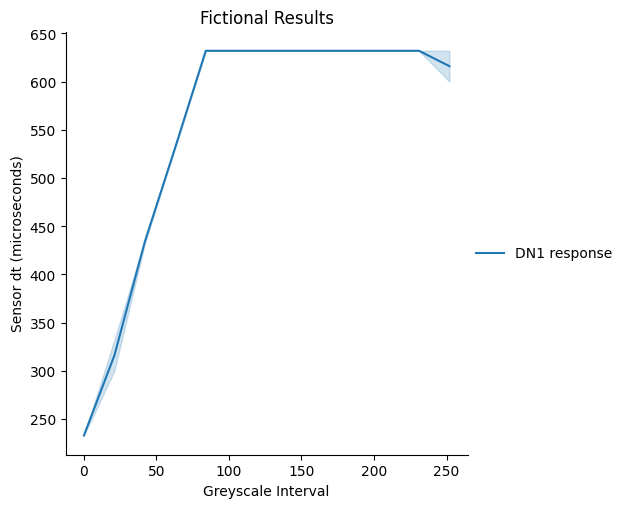

In [3]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a line plot with
# the region of error around the line.

# We use numpy to create an array of values
# Panda dataframes want arrays not lists.
import numpy as np

# We will use a library called Seaborn to
# make our plot for us, so we import it.
import seaborn as sns

# We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the array
# like the following.
# This allows multiple data entries per
# point on the x axis.
# Columns as:
# [ <greyscale>, <measurement> ]
results_dn1 = np.array(
[ [0, 233],   # you will have 10 repeats for each greyscale
  [0, 233],
  [21, 300],
  [21, 332],
  [42, 436],
  [42, 432],
  [63, 532],
  [63, 532],
  [84, 632],
  [84, 632],
  [105, 632],
  [105, 632],
  [126, 632],
  [126, 632],
  [147, 632],
  [147, 632],
  [168, 632],
  [168, 632],
  [189, 632],
  [189, 632],
  [210, 632],
  [210, 632],
  [231, 632],
  [231, 632],
  [252, 632],
  [252, 600] ] )

# Reformat the data using pandas
results_dn1 = {"DN1 response": pd.Series(results_dn1[:,1], index=results_dn1[:,0]) }
dataframe = pd.DataFrame( results_dn1 );

# We can now plot both datasets at the same time.
# Note, data=combined!
plot = sns.relplot(data=dataframe, kind="line")
plot.set(xlabel ="Greyscale Interval", ylabel = "Sensor dt (microseconds)", title ='Fictional Results')

<hr><br><br><br><br>

## Exercise 3: Multiple Sensors

In the previous two exercises we have worked with one line sensor, `DN1`.  We have collected measurements and inspected the results, validating that the code works.  This has also helped us to understand the performance of the sensor.

In this exercise we will write code to use all the line sensors more easily, this means `DN1`, `DN2`, `DN3`, `DN4` and `DN5`.

To create this functionality, there are two main approaches we can take that both involve creating our own function:
- copy and paste Algorithm 1 code for each sensor, changing the pin assignment.  This would create 5 seperate functions, and we can then name them something like `readLineSensor1()`, `readLineSensor2`, `readLineSensor3`, etc.
- write 1 function, and use the argument (input) to the function to select which sensor is being read.  We might call this function `readLineSensor(number)`

In general, it is preferable to use the second case.  One reason for this is because we would write less code overall, and this means there would be less code for bugs (errors) to occur.  For example, if we did copy-and-paste 5 times, and later we realised there was an error, we would need to make sure we changed this in all 5 functions.  It would be easy to forget this, and spend many hours wondering why your robot has odd behaviour.  Do not underestimate how much time programming is spent debugging!


```c
#define EMIT_PIN    11    // Documentation says 11.
#define LS_LEFT_PIN ????   // Complete for DN1 pin
#define LS_MIDLEFT_PIN ????   // Complete for DN2 pin
#define LS_MIDDLE_PIN ????   // Complete for DN3 pin
#define LS_MIDRIGHT_PIN ????   // Complete for DN4 pin
#define LS_RIGHT_PIN ????   // Complete for DN5 pin

// Store our pin numbers into an array, which means
// we can conveniently select one later.
// ls(line sensor)_pin
int ls_pins[5] = {LS_LEFT_PIN,
                  LS_MIDLEFT_PIN,
                  LS_MIDDLE_PIN,
                  LS_MIDRIGHT_PIN,
                  LS_RIGHT_PIN };


#define MAX_SAMPLES ????
float results[ MAX_SAMPLES ]; // An array of MAX_SAMPLES length

void setup() {

  // Set some initial pin modes and states
  pinMode( EMIT_PIN, INPUT ); // Set EMIT as an input (off)
  pinMode( ????, INPUT );     // Set line sensor pin to input

  // Start Serial, wait to connect, print a debug message.
  Serial.begin(9600);
  delay(1500);
  Serial.println("***RESET***");

} // End of setup()


void loop() {

  // Collect MAX_SAMPLES readings.
  for( ?????; ??????; ??????) {

    // This calls our new function, which you need
    // to complete below.  As a result, this should read DN1
    // and save the reading into results[i].
    results[i] = readLineSensor( 0 );  
    delay(200);

  }


  // The section below has been completed for you.
  // Use this section to build a similar construct
  // around the code above, so that results[i] is
  // indexed from value 0 to MAX_SAMPLES.
   
  // The robot will be "stuck" here forever, because
  // the condition true will never change.
  // Therefore, the robot will Serial Print the
  // results back to your computer every 1000ms.
  while( true ) {
      Serial.println("Results: ");
      for( int i = 0; i < MAX_SAMPLES; i++ ) {
        Serial.println( results[i] );
      }
      delay(1000);
  }

} // End of loop()


// A function to read a line sensor.
// Specify which sensor to read with number.
// Number should be a value between 0 and 4
float readLineSensor( number ) {

    // These two if statements should be
    // completed to prevent a memory error.
    // What would be a good value to return that
    // would not be mistaken for a sensor reading?
    if( number < 0 ) {
        return ?????;
    }
    if( number > 4 ) {
        return ?????;
    }


    // Complete the steps referring to the pseudocode block
    // Algorithm 1.
    // The first steps have been done for you.
    // Fix parts labelled ????
    // Some steps are missing - add these.
    pinMode( EMIT_PIN, OUTPUT );
    digitalWrite( EMIT_PIN, HIGH );

    // In this line, we retrieve the pin value
    // stored in the array "ls_pins" at location
    // "number".  So it is like a look-up table.
    // We can think of ls_pins in memory like:
    // Index 0, Index 1, Index 2, Index 3, Index 4
    //[  DN1  ][   DN2 ][  DN3  ][  DN4  ][  DN5  ]
    pinMode( ls_pins[ number ], OUTPUT );

    digitalWrite( ????, HIGH );
    delayMicroseconds( 10 );
  
  
    unsigned long start_time = micros();

    while( digitalRead( ???? ) == ???? ) {
        // Do nothing here (waiting).
    }

    unsigned long end_time = ?????;

    pinMode( ?????, INPUT );

    unsigned long elapsed_time = end_time - start_time;

    // Give the result back to wherever this
    // function was called from.
    return (float)elapsed_time;
}
```

1. In the above example code for `readLineSensor(number)`, the function begins with two if statements to capture an error condition.
  - **Hypothesise:** what do you predict would happen if we did not catch this error, and a value such as `5` was passed into the function?
  - **Hypothesise:** given what we have understood about the sensor readings from Exercises 1 and 2, what would be a good value to return that would not be mistaken as a sensor reading?
  - **Validate:** Test your code by passing a value of `5` to `readLineSensor()`, and also use `Serial.println()` to report to you that an incorrect value was caught.

2. Complete the above example code, replacing all areas marked `????` and adding in any missing lines of code.  
  - Most of these can be drawn from your solutions for Exercise 1 and Exercise 2.
  - It will help significantly if you comment your own code to explain each step, and you can then compare this against the pseudocode to check your code is complete.

3. Repeat the last part of Exercise 2 (graphing results) for each of the remaining sensors `DN2`, `DN3`, `DN4`, `DN5`.  
  - There is an updated Python example below that includes arrays for the other sensors, so that you can have multiple plots on one graph.
  - **Validate:** check that all your sensors are working as you would expect.  
    - It is normal to see some difference between the sensors.  This is primarily because of variability in the manufacturing process.


<ipython-input-4-91a1d41e2132>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append( pd.DataFrame( results_dn2 ) );


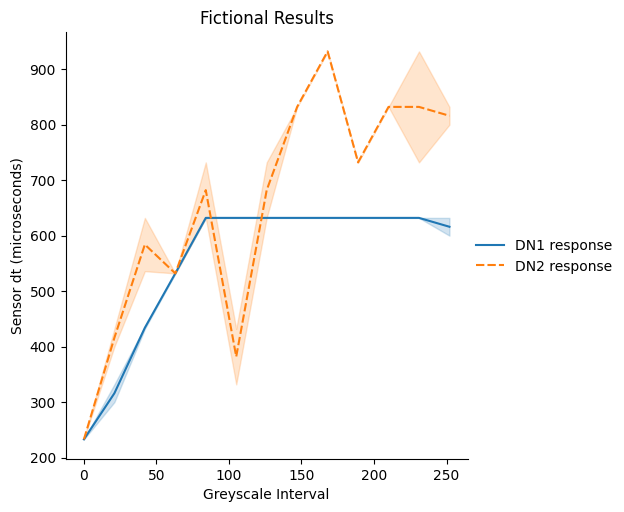

In [4]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a line plot with
# the region of error around the line.

# We use numpy to create an array of values
# Panda dataframes want arrays not lists.
import numpy as np

# We will use a library called Seaborn to
# make our plot for us, so we import it.
import seaborn as sns

# We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the array
# like the following.
# This allows multiple data entries per
# point on the x axis.
# Columns as:
# [ <greyscale>, <measurement> ]
results_dn1 = np.array(
[ [0, 233],   # you will have 10 repeats for each greyscale
  [0, 233],
  [21, 300],
  [21, 332],
  [42, 436],
  [42, 432],
  [63, 532],
  [63, 532],
  [84, 632],
  [84, 632],
  [105, 632],
  [105, 632],
  [126, 632],
  [126, 632],
  [147, 632],
  [147, 632],
  [168, 632],
  [168, 632],
  [189, 632],
  [189, 632],
  [210, 632],
  [210, 632],
  [231, 632],
  [231, 632],
  [252, 632],
  [252, 600] ] )

# Reformat the data using pandas
results_dn1 = {"DN1 response": pd.Series(results_dn1[:,1], index=results_dn1[:,0]) }
dataframe = pd.DataFrame( results_dn1 );

results_dn2 = np.array(
[ [0, 233],
  [0, 233],
  [21, 400],
  [21, 432],
  [42, 536],
  [42, 632],
  [63, 532],
  [63, 532],
  [84, 632],
  [84, 732],
  [105, 432],
  [105, 332],
  [126, 632],
  [126, 732],
  [147, 832],
  [147, 832],
  [168, 932],
  [168, 932],
  [189, 732],
  [189, 732],
  [210, 832],
  [210, 832],
  [231, 932],
  [231, 732],
  [252, 832],
  [252, 800] ] )

# Reformat the data using pandas
results_dn2 = {"DN2 response": pd.Series(results_dn2[:,1], index=results_dn2[:,0]) }
dataframe = dataframe.append( pd.DataFrame( results_dn2 ) );

# We can now plot both datasets at the same time.
# Note, data=combined!
plot = sns.relplot(data=dataframe, kind="line")
plot.set(xlabel ="Greyscale Interval", ylabel = "Sensor dt (microseconds)", title ='Fictional Results')

## Exercise 3: Improving the Example

The example code provided above has significant room for improvement.  For now, we will continue working with just 1 sensor.  

The below code extract is the part of the routine that waits for the `digitalRead()` measurement to go `LOW`.  Currently, in extreme cases the sensor may take approximately 2400 microseconds (2.4milliseconds) to complete on a very black surface.  Furthermore, an ambient light measurement (if the IR LEDs are off) can exceed 5000microseconds (5millisceonds).  In both cases, millisecond durations are quite long and undesirable.   Whilst your 3Pi+ is within `while( digitalRead( LS_LEFT_PIN ) == HIGH )` it cannot read other sensors or change motor power, etc.  This is called `blocking` code.  

```c

  // Begin measurement of time in
  // microseconds
  unsigned long start_time;
  unsigned long end_time;
  start_time = micros();

  // Stay in a loop whilst the capacitor
  // is still registering as "HIGH".
  while( digitalRead( LS_LEFT_PIN ) == HIGH ) {
    // Do nothing
  }

  // record end time
  end_time = micros();

  // Calculate elapsed time
  unsigned long elapsed_time;
  elapsed_time = end_time - start_time;

```

In the above code extract, we can see that the `while()` loop is very inefficient.   The `while()` loop **blocks** our code, not executing any instructions beyond checking the `conditional statement`.  The program is left "waiting" for the sensor read to complete.  This `while()` loop could also run for an indeterminate (unknown) amount of time if there was an error or bug somewhere (e.g., if the `digitalRead()` never returned `LOW`)- this is not very safe code.

We can imagine a better algorithm that allows the operation to stop itself if it is taking too long:

```c
void loop() {

  // Add code here to:
  // - configure your IR LEDS (EMIT pin)
  // - Charge the capacitor
  // - configure sensor pins to read

  // We are interested in the elapsed
  // time for the sensor read.
  unsigned long sensor_time;

  // Begin measurement of time in
  // microseconds
  unsigned long start_time;
  start_time = micros();

  // Use a flag to capture if the sensor
  // read is complete.
  // Set to false (not done) initially.
  bool done = false;

  // We want to stop the process if it takes
  // too long. Here, we will set a "time out"
  // value to compare against.
  unsigned long timeout = 5000;

  // We will use the general flag "done" to
  // decide if we should continue waiting.
  // ( "done is not true", so run while loop)
  while( done != true ) {
    
    // Get current time
    unsigned long current_time = micros();

    // Determine elapsed time
    unsigned long elapsed_time = current_time - start_time;

    // Check if we have been waiting too long
    // If true, break from the loop.
    if( elapsed_time >= timeout ) {

        done = true;
        sensor_time = timeout;
    }

    // If the pin has gone low, then the
    // read is complete.  Save elapsed time
    // and change done flag to true.
    if( digitalRead( LS_LEFT_PIN ) == LOW ) {

        sensor_time = elapsed_time;
        done = true;
    }

  } // end of while loop


} // end of main loop()

```

1. Integrate the above example into your code.  Rememeber to keep or add:
  - code to enable the IR LEDs (EMIT pin).
  - code to charge the capacitor prior to the read operation.
  - code to re-configure the sensor input pins to be read.

2. In the above example, when a "time out" occurs the variable sensor_read is set to the `timeout` value.  We can imagine that elsewhere in your code the variable `sensor_time` will be used to effect a behaviour.
  - when you write code in the future, how might you `disambiguate` a valid sensor read from a time out value?
  - in the future, you might perform more complex calculations on the value stored in `sensor_time`.  What would be a better datatype?

3. In the above code, `timeout` has been set to `5000`.  What is a more useful or sensible `time out` value?  Inspect the graph you have plot in Exercise 2.5 to justify your decision.  

4.  Once you are happy you have the above code working, create a new function to complete your sensor read operation.  
  - Adjust your main `loop()` to look something similar to:

```c
void loop() {

  // Perform sensor read
  readLineSensor();

}

// Line sensor read function
void readLineSensor() {
  // Code previously developed above.
}
```



<hr><br><br><br><br>

## Multiple Sensors

A simple solution to read all 3 line sensors would be to repeat the above procedure sequentially, one after the other, for each sensor `DN1`, `DN2` and `DN3`.  

You might even be inclined to "copy and paste" your code, changing the pin numbers for each instance.  

However, intuitively, this would mean that the overall time taken to update the sensors would be the sum of the time for each to complete in sequence.  This is not efficient, and it is generally undesirable that our robot should be waiting for something to finish.  

<p align="center">
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_LS_SerialRead.png?raw=true">
</p>

Instead, we can conduct the read process in parallel by setting the appropriate pins, and recording an elapsed time for each sensor concurrently as they complete:  

<p align="center">
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_LS_ParallelRead.png?raw=true">
</p>

It takes very little time for the microcontroller to set the mode and state of a `GPIO` pin, or to take a digital reading.  If we place all three of our `digitalRead()` operations within the `while()` loop of our sensor read procedure, we can consider this to be an approximation of a parallel read of the digital pins.  In this parallel method, the whole sensor update would only take as long as the longest individual sensor read procedure to complete.   

It should also be the case that, after the previous exercise, the longest time to complete a read of all the sensors concurrently will be a known and restricted to the `timeout` value you have set. This will help to make the general execution of our program easier to anticipate.

To help with this procedure, we can utilise an `array` of a variable.  Using an array means that we will be able to **iterate** through it - or in other words, our algorithm can repeat sections of code but change key parameters by itself.  In our situation, we will presently read 3 sensors, and later we may want to instead read all 5 sensors.

The following line creates an array of 3 elements, and sets their initial values:

```c
// Define which pins the sensors are
// attached to. These values are taken
// from the online documentation.
#define LS_LEFT_PIN   A0
#define LS_CENTRE_PIN A2
#define LS_CENTER_PIN A3

// Define the max number of sensors to use.
// Note, this will operate like a "find-and-replace",
// inserting 3 when NB_LS_PINS is used in your code.
#define NB_LS_PINS 3

// We can create an array ("list") of sensors
// to check.  Just using the pin numbers we
// have explored before.
// Note, we should match the number of entries
// to the max number of sensors we are reading.
int ls_pin[NB_LS_PINS] = { LS_LEFT_PIN, LS_CENTRE_PIN, LS_RIGHT_PIN };
```

When we have written:
```c
// This creates space to store 3 consecutive
// integers in memory.
int ls_pin[3];
```
This tells the compiler we will access an `integer` stored in 3 consecutive locations in memory.  Later on in the code, we can read from these locations by placing a valid index number into the square brackets (`[ ]` ):

```c
// We could read each element like so:
value1 = ls_pin[0];
value2 = ls_pin[1];
value3 = ls_pin[2];

// Trying to read element 3 would cause
// an error, possibly causing your 3Pi+
// to Reset.  
// This is because there are only elements
// 0, 1, 2 (counting from 0, no 3).
value4 = ls_pin[3];
```
When we read from an array, we must be careful not to index beyond the length of the array declared.  In the above, the index counts up from 0, so an index of `3` accesses undefined memory.  This can be a nasty bug, hard to spot in your code, and can cause your 3Pi+ to reset unpredictably.  

Looking back to the above example, we had:

```c
int ls_pin[NB_LS_PINS] = { LS_LEFT_PIN, LS_CENTRE_PIN, LS_RIGHT_PIN };
```

Here, `= { LS_LEFT_PIN, LS_CENTRE_PIN, LS_RIGHT_PIN };` has been used to set the initial values when the array `ls_pin[] `is decalred.  We need to set 3 initial values (separated with comma's) because the array is defined as 3 elements long.  In the above, these are the `#define` statements we have used earlier, so it will be the pin numbers which are stored into this array.

Arrays are convenient if we are going to sequentially access data.  For this exercise, we want to update all of our line sensors.  Therefore, we can use a loop and to cycle through an array.  

## Exercise 4: Implementing Multiple Sensors





In the below example, `for()` loops are being used to iterate over variables declared as arrays.  This may look confusing at first, but it is a very useful and practical way to write code.  For loops have the general form of:

```c
for( <initial value>; <operating condition>; <incrementing operation> ) {

}

// This would loop with `i`, repeating 10 times,
// (e.g. while i < 10 ), incrementing i by 1 on
// each iteration (i++, or i += 1, or i = i + 1):
// i = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
for( int i = 0; i < 10; i++ ) {

}

```

Example parallel sensor read code:
```c

// Define which pins the sensors are
// attached to. These values are taken
// from the online documentation.
#define LS_LEFT_PIN   A0
#define LS_CENTRE_PIN A2
#define LS_RIGHT_PIN A3

// Define the max number of sensors to use.
#define NB_LS_PINS 3

// We can create an array ("list") of sensors
// to check.  This becomes very useful to allow
// us to write code which iterates, rather than
// needing to repeat lines of similar code.
// Note, we should match the number of entries
// to the max number of sensors we are reading.
int ls_pin[NB_LS_PINS] = { LS_LEFT_PIN, LS_CENTRE_PIN, LS_RIGHT_PIN };

// We will use "which" to index through each
// sensor.  Naming this variable "which" should
// improve the readability of our code later.
// You could use something else.
int which;

// We still need to record the start time.
unsigned long start_time;
start_time = micros();

// Multiple sensors, needs multiple places
// to store the measurement result.
// We follow the convention above to create
// another array to store 3 values.
unsigned long sensor_read[ NB_LS_PINS ];

// This time, let's use a count to check how
// many sensors have finished reading.  Let's
// set it to NB_LS_PINS (3), and count down to
// zero.  Therefore, remaining == 0 will mean all
// sensors complete.
int remaining = NB_LS_PINS;


// While we still have sensors to read.
while( remaining > 0 ) {
  
  // Add code to calculate the current elapsed time
  // here.

  // Whilst we are not done, we repeatedly attempt
  // to read the sensors.  We read the sensors in
  // a loop.  "which" will be 0,1,2 before moving on
  // with the code in this while loop.
  for( which = 0; which < NB_LS_PINS; which++ ) {

    // We can instruct a digitalRead() using our
    // array variable to drop in the correct pin
    // number.  Here, "which" is incrementing
    // 0, 1, 2, looking up the pin value inside
    // ls_pin[].
    // Here, if digitalRead() returns LOW, it means
    // this sensor has completed.  
    if( digitalRead( ls_pin[ which ] ) == LOW ) {

        // Check if this sensor has had a previous
        // value of elapsed time stored before.
        // We only want to store the EARLIEST
        // elapsed time, not store subsequent values.
        if( sensor_read[ which ] == ?????? ) {

          // record the elapsed time on this iteration
          // of the while() loop as the completion time
          // for this sensor
          sensor_read[which] = elapsed_time;

          // Inside this if() means it is the first
          // and only time this sensor ("which") will
          // be updated.  Therefore, we reduce the
          // "remaining" count toward 0.
          // Therefore, each decrement corresponds to
          // a unique sensor.
          remaining = remaining - 1;

        }

    } // end of if( digitalRead() )

  } // end of for() looping through each sensor.

  // Here, we make a final check to see if the
  // whole read operation is taking too long.
  if( elapsed_time >= timeout ) {

      // Here, you may need to set an appropriate
      // sensor_read[ which ] value to indicate a
      // timeout.  An appropriate initial value of
      // sensor_read[] could mean this step isn't
      // necessary.

      // Set remaining to 0 to force end of while()
      remaining = 0;
  }


} // end of while( remaining > 0 )

```

The above code extract contains elements of code which may be useful.  However, in it's current format it will not compile or run.  The code represents some useful "ingredients" for you.  

1. Why might it be useful to `#define` how many line sensors are being used at the top of your program?
  - **Help:** we have discussed a serious error when using arrays.
  - **Help:** how many line sensors does the 3Pi+ have?

2. The above example code is missing the operation to calculate the `elapsed_time` on every iteration of the `while()` loop.  We have used this previously.
  - implement a method to record the `start_time` outside the `while()` loop.  Why must this be outside the `while()` loop?
  - implement a calculation of `elapsed_time` inside the `while()` loop. Why must this be inside the `while()` loop?

3. Integrate the above example code into your existing code for a single sensor.  
  - Remember to keep versions of your code as you work.
  - Remember to keep the operation to **enable the IR LEDs** (EMIT pin).
  

4. Implement a short routine using a `for()` loop (following a similar structure above) to:
  - Operate the capacitor charging for each sensor, `DN1`, `DN2`, `DN3`.
  - Re-configure the sensor pins `DN1`, `DN2`, `DN3` to be read again.
  - Place this **before** the `while( remaining > 0 )` loop - why must this be before the `while()` loop?

5. In the above example, there is the following comment and statement:

```c
        // Check if this sensor has had a previous
        // value of elapsed time stored before.
        // We only want to store the EARLIEST
        // elapsed time, not store subsequent values.
        if( sensor_read[ which ] == ?????? ) {
```
  - What would be the effect or problem of storing subsequent values?
  - What would be a potential effect of decreasing our `remaining` variable when only 1 sensor is returning `LOW` on `digitalRead()`?
  - We could set the variables `sensor_read[ ]` to a known initial value, above represented as `???????`.  If this initial value is seen, the algorithm would know it has not been updated to a value of `elapsed_time`.  Once `elapsed_time` has been recorded into `sensor_read[]`, it would mean the initial value would be lost and this if() statement would not be true again.
  - What initial value would be effective?  There are three sensible answers to this question.  
  - Replace `?????` with your initial value so the code will compile and work.


6. **Validate:** Use your robot, environment, and the Serial Monitor to confirm that your solution is working.
  - Given your experience of the previous exercises - what would you expect to see in a working solution?
  - Given your experience of the previous exercises what would indicate to you something is going wrong?
  - **Help:** Common bugs in this exercise are:
    - Only 1 sensor is being updated: check that you are decreasing the variable `remaining` only once for each sensor (e.g., each decrement must be a unique occurence).
    - The routine always ends with `timeout`: check that the IR LEDs are enabled (EMIT pin).

7. **Evaluate:** Utilise a new set of variables to capture the execution time for the parallel read procedure.  It should take the general format in the example below.  Compare your execution time with your peers:  
  - Have they achieved more efficient code?  
  - What techniques have they used?  
  - Can they explain it to you so that you understand?  
  - Or can you explain your solution to your peer so they understand?
  - **Help**: explaining code or solutions to others is a great way to solve problems and to improve your understanding.  Don't forget that you can also ask a member of teaching staff to help you.  

```c
void loop() {

  // Store the time before.
  unsigned long exec_time_start;
  exec_time_start = micros();

  // Call the parallel sensor read routine we
  // have been working on.
  doParallelSensorRead();

  // Store the time afterwards
  unsigned long exec_time_end;
  exec_time_end = micros();

  // Report total execution time
  Serial.println( (exec_time_end - exec_time_start) );

  // A short delay to keep the timing
  // of this code consistent for now.
  delay(100);

}

```

<hr><br><br><br><br>

## Exercise 5: Refactor

At this stage, you should now have a number of variables and processes all related to the operation of your line sensors.  Similar to developing code for the motors, this is likely spread across:
- `global` scope
- `setup()`
- `loop()`
- other functions you may have created.

1. **Refactor:** Take a look at your code and consider any elements of code which could be placed into their own functions.  Doing so will improve the readability of your code and likely decrease your time spent debugging errors.  Three good examples are:
  - `enableIRLEDs();`
  - `disableIRLEDs();`
  - `chargeCapacitors()`;

2. **Refactor:** Follow the same process to populate a `class` specifically for the line sensors.
  - decide if you will use a class to opeate a single line sensor, or all of them together as a subsystem.  Given the above exercises, what might be more computationally efficient or appropriate for our robot?
  - remember to create an `instance` of your `class` in `global` scope of your main sketch file (.ino).
  - remember to create an initialising function within the class to set the initial mode and state of pins.
  - remember to call this initialising function within `setup()`
  - an empty class template named `linesensor.h` is included in the template Arduino sketch available onGithub (<a href="https://github.com/paulodowd/EMATM0054_22-23/tree/main/3PI_CodeStub">Github Page</a>, <a href="https://github.com/paulodowd/EMATM0054_22-23/raw/main/3PI_CodeStub/Labsheet_X.zip">Download Link for Zip file</a>).
  - work slowly and methodically, testing the code compiles as you go.
  - test that your class file is operating correctly with no bugs.


<hr><br><br><br><br>

# Multi-tasking with millis()

In this final section, we will take what we have learnt about operating the line sensors with `micros()` and develop a new general technique to help organise which tasks are executed and when.  

So far in our software for the 3Pi+ we have written all our code within the `loop()`.  We have written this code to execute on every iteration.  In the examples, you may have noticed the following line at the bottom of `loop()`:

```c
  // A short delay to keep the timing
  // of this code consistent for now.
  delay(100);
```
Here, `delay(100)` has been used to create a consistent timing for the `loop()` execution.  In general, it is useful to attempt to make your program execution as predictable as possible.  Most often, we will evaluate our robotic system `empirically` - meaning, through observation of it's activity.  If our software is unpredictable, it becomes very difficult to understand what the robot is doing, or to diagnose any faults.  From software alone, theory or logic can not reveal the performance of the robot.  Our robotic system is `situated` and `embedded` within the environment - we expect the robot and the environment to necessarily interact to produce useful behaviours.  

However, the `delay()` function is code which `blocks` execution.  The Arduino Reference states:
> No other reading of sensors, mathematical calculations, or pin manipulation can go on during the delay function, so in effect, it brings most other activity to a halt.

Using `delay()` means that our robot essentially stops processing for the requested interval.   Obviously, this would mean our robot might not be able to respond to a change in the environment.  When we have used `delay(100)` (halting execution for 100 milliseconds), we have essentially forced `loop()` to execute at a slow rate of 10 times a second (10hertz, 10hz).  Remember that `loop()` is not called again until the `loop()` function itself finishes (returns).  

An obvious solution might be to remove the `blocking` function `delay()`.  However, now our `loop()` will execute in an uncontrolled way.  This means that the timing of `loop()` may change per iteration depending on which code has been run.  As we have observed with our line sensor measurement process - the timing of the code can vary.  This might seem like a minor issue, but it will become significant as the complexity of your program (and robot behaviour) increases.  

In the future, we might have a number of tasks to update within `loop()`, for example:
- reading the line sensors
- updating the line following behaviour
- measuring the angular velocity of the wheels
- calculating a feedback signal for the motor control
- calculating odometry to track the robot position
- monitoring the robot progress through the series of tasks
- reporting debug information back to you
- etc.

Each of the above subtasks will have a different level of priority within the system.  We can also ask ourselves which subtasks need to be responded to quickly, and which others can be updated slowly. For example:
- **fast reponse:** responding to changes in the position of the line under the robot.  If we don't update this quickly enough, the robot might lose track of the line.  
- **slow response:** updating the tracking of the robot progress through the whole line following challenge.  Transitions through desired behaviours might necessarily be slow - e.g., we might permit the robot to come off the line for 2 seconds before we consider it "lost".  

If we can instead schedule subtasks in time, we can improve our code with the following rationale:
- subtasks that do not require high frequency updates can be given an infrequent execution, which means they do not consume computing resources on the remaining `loop()` cycles.
- your code can be organised with a regular update cycle that takes account for operations with `non-deterministic` execution - such as the known variability of time for the line sensor reading process.  
- the readability of your code can be improved, because it will be clear what parts of the program are executing when - as opposed to a long sequential script with no `flow control` (<a href="https://en.wikipedia.org/wiki/Control_flow#:~:text=In%20computer%20science%2C%20control%20flow,from%20a%20declarative%20programming%20language.">control of flow</a>).


## Example:

```c
// Global definition of the time interval
#define LINE_SENSOR_UPDATE 100
#define MOTOR_UPDATE       2000

void loop() {

  // Record the time of this execution
  // of loop for coming calucations
  //  ( _ts = "time-stamp" )
  unsigned long current_ts;
  current_ts = millis();


  // Run our line sensor update
  // every 100ms (10hz).
  // Tracking time for the line sensor (ls)
  elapsed_t = current_ts - ls_ts;
  if( elapsed_t > LINE_SENSOR_UPDATE ) {
      
      // Conduct a read of the line sensors
      readLineSensors();

      // Record when this execution happened.
      // for future iterations of loop()
      ls_ts = millis();

  }

  // Just to test this process:
  // Alternate the motor activation
  // every 2 seconds so that the 3Pi+
  // drives fowards, then backwards.
  elapsed_t = current_ts - motor_ts;
  if( elapsed_t > MOTOR_UPDATE ) {
      // Toggle motor direction
      // ...
      
      // Write motor direction and
      // pwm to motors.
      // ...

      // Record when this execution happened
      // for future iterations of loop()
      motor_ts = millis();

  }

  // Delay no longer being used.
  // delay(100)

}


```

In the above example, you should be able to recognise the familiar form of the following code:
```c
  elapsed_t = current_ts - ls_ts;

  elapsed_t = current_ts - motor_ts;
```

This follows the same principle we have used for the line sensor measurement, the time for the capacitor to discharge (except, we are now using `millis()`):
<p align="center">
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/time_elapsed.png?raw=true">
</p>

In the above example, `current_ts` is $t_{2}$, or the current time that `loop()` is executing.  `ls_ts` (line-sensor time-stamp) and `motor_ts` (motor time-stamp) are **historic** values of time, or $t_{1}$.  We use the time since $t_{1}$ to only update the motors or line-sensors once a defined period of time has elapsed.  

When the correct time has elapsed, it is necessary to advance the value of $t_{1}$ (the historic value) to the current time, so that the code does not execute again until the correct amount of time has elapsed once more.  We can observe this operation in the following two lines of code, for each subtask:

```c
      // Record when this execution happened.
      // for future iterations of loop()
      ls_ts = millis();
```

```c
      // Record when this execution happened
      // for future iterations of loop()
      motor_ts = millis();
```

If this is still confusing, it is recommended to draw a timeline on paper, and to follow the code procedure by hand, drafting a table of values for $t_{elapsed}$, $t_{1}$ and $t_{2}$ with respect to time in the context of either the motor or line sensor schedule tasks.  



## Exercise 6: Schedule the Line Sensor Read

1. **Decompose the Problem:** Write a very short program to test how fast `loop()` operates with a minimum of code and without any calls to `delay()`:  
  - use `micros()` and calculate the elapsed time, and report this back to your computer Serial Monitor using `Serial.print()`.
  - because we are timing `loop()` itself, you'll need to use a `global` variable to capture the previous time of execution.
  - given the time interval reported, what is this as a frequency in Hertz?

2.  **Hypothesise:** In the example code provided above, why would it be a bad idea to use the following conditional statement?

```c
      if( elapsed_t == MOTOR_UPDATE ) {
```

3. In the above example, the following line of code updates a time-stamp (records the count of milliseconds at that moment) within the `if()` statement that calls the `lineSensorRead()` function.  Why is this necessary?  What would happen if this time-stamp was not updated, in terms of code execution?  
  - **Help**: Consider the calculation of `elapsed_t`.

```c
      // Record when this execution happened.
      // for future iterations of loop()
      ls_ts = millis();
```

4. The above code example is **incomplete** and will not compile without errors.  Complete the code example above so that you can upload it to your 3Pi+:
  - If you have not done so already, it is highly recommended to `refactor` your line sensor reading process code into a function, such as `readLineSensors()`.  
    - in C, it is a little tricky to return more than one variable.  For the level of these exercises, it is acceptable to have your function update variables declared in `global scope`.
  - Refer to your work for Labsheet 2 to operate the motors.  You should have written functions for the safe and confident operation of your motors.
  - Add extra functionality to the example:
    - Use `pinMode()` and `digitalWrite()` to activate the built-in LED when the robot is above a black surface.
    - It is recommended to use the `Yellow LED` referred to in the <a href="https://www.pololu.com/docs/0J83/5.9"> documentation pin assignments </a>.  Remember to use the pin value in the column `Arduino Pin Names`.
    - Exeperiment with moving this LED activation code into the different scheduled tasks, or outside of them within `loop()`.
